# Ford go bike- Key Insights
## by Ritu

## Investigation Overview

In this investigation, I want to explore the answers of following questions
1. What is the average bike ride duration?
2. Weekend vs weekday ridership?
3. Which user_type rides more?
4. Which age group and gender class uses most of the service?

## Dataset Overview

The data used in this project is for Feb,2019. The data consisted of ride durations and attributes of approximately 183412 rides. The attributes included start time, end time, user type, birth year, start station , end station. Duration_sec has very large of values with few very high outliers, so the values till 99%ile are taken and rest removed. Also for records wherein age of rider is more than 100 years are removed too. 75 such records are removed.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
bike = pd.read_csv('201902-fordgobike-tripdata.csv')

In [4]:
# Converting start and end_time to datetime fomat
bike['start_time'] = pd.to_datetime(bike['start_time'])
bike['end_time'] = pd.to_datetime(bike['end_time'])

# Converting start_station_id  and end_station_id  to string type
bike['start_station_id'] = bike['start_station_id'].astype(str)
bike['end_station_id'] = bike['end_station_id'].astype(str)

# Adding age column to the dataset
now = pd.Timestamp('now')
yr = now.year

# calcualting age of riders
bike['age']= yr-bike['member_birth_year']

# Binning the time of day into 4 bins
bins = [0, 6, 12, 18, 24]
labels = ['00:00-05:59', '06:00-11:59', '12:00-17:59', '18:00-23:59']
bike['time_bin'] = pd.cut(bike['start_time'].dt.hour, bins, labels=labels, right=False)

# Adding daytype column to the dataset.
bike['daytype']= np.where(bike['start_time'].dt.weekday <5 ,'weekday' ,'weekend' )

# setting the time_bin into order

ordered_time= pd.api.types.CategoricalDtype(categories=labels, ordered= True)
bike['time_bin'] = bike['time_bin'].astype(ordered_time)

## Average bike ride duration

When plotted on a log scale, the duration has normal distribution with peak around 500 seconds.


In [5]:
#The max value is far away from 75 %ile. There are many outliers. 
#To handle this lets remove all the records having duration_sec more than in 99 %ile
bike_99= bike[bike['duration_sec'].between(bike['duration_sec'].quantile(0),bike['duration_sec'].quantile(.99))]

bike_final= bike_99[bike_99['age']<= 100]

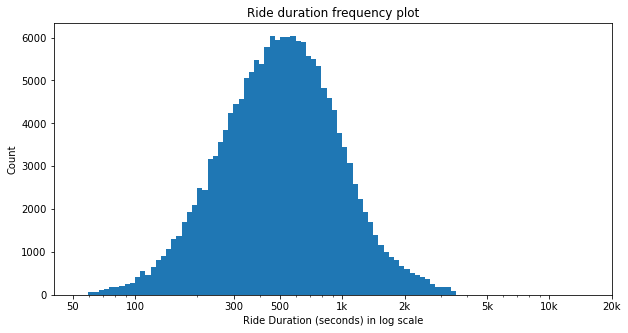

In [29]:
# there's a long tail in the distribution, so let's put it on a log scale instead
plt.figure(figsize =[10,5])
binsize_log = 0.025
bins=10** np.arange(1.7,np.log10(bike_final['duration_sec'].max())+binsize_log,binsize_log)
plt.hist(bike_final['duration_sec'], bins = bins)
plt.xscale('log')
plt.xticks([50,100,300,500, 1e3, 2e3, 5e3, 1e4, 2e4], [50,100,300,500, '1k', '2k', '5k', '10k', '20k'])
#plt.xlim((0,2e4))
plt.xlabel('Ride Duration (seconds) in log scale')
plt.ylabel('Count')
plt.title('Ride duration frequency plot')
plt.show()

## User_type riding more

Subscriber base is riding more bikes than other customers


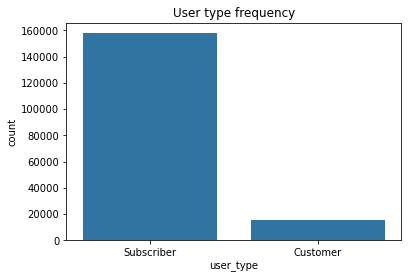

In [28]:
sb.countplot(data = bike_final , x = 'user_type', color= color_base)
plt.title('User type frequency')
plt.show()

## Age group and gender class availing most of the service

25-35 years of people are mostly riding the bikes with males predominant in gender section.


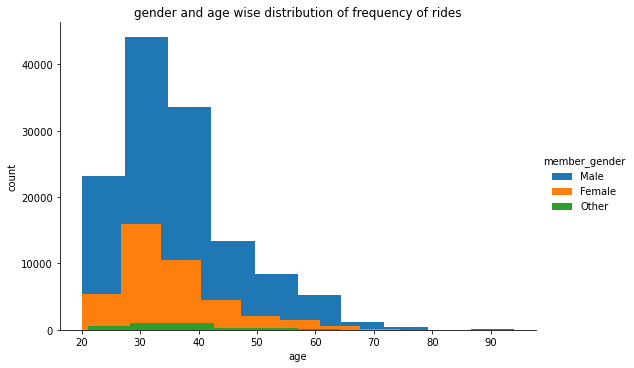

In [30]:

g= sb.FacetGrid(data = bike_final , hue = 'member_gender', aspect= 1.5, height= 5)
g.map(plt.hist , 'age')
g.add_legend()
plt.xlabel('age')
plt.ylabel('count')
plt.title('gender and age wise distribution of frequency of rides')
plt.show();

## Weekend vs weekday ridership

During weekdays more rides are happening which totally makes sense.

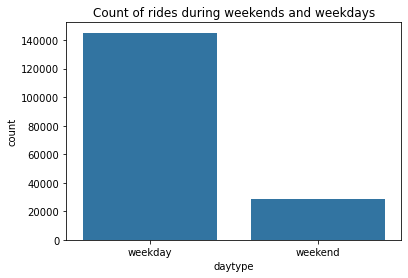

In [31]:
color_base = sb.color_palette()[0]
sb.countplot(data = bike_final , x = 'daytype', color= color_base)
plt.title('Count of rides during weekends and weekdays')
plt.show();

## Weekend vs weekday mean ride duration

Mean ride duration during weekends is more than weekdays

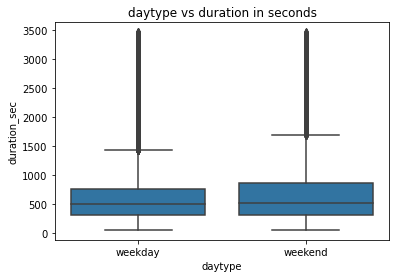

In [42]:

sb.boxplot(data = bike_final, x = 'daytype', y = 'duration_sec', color = color_base)
plt.title('daytype vs duration in seconds')
plt.show()

## Mean trip duration by day of week and hour of day


We observed that weekdays has more bike demand over weekends and mean riding duration in weekends is more than weekdays.
Now lets see for each of day of week and hour of a day what is the distribution of ride duration. This can be achieved using heatmap.As seen from heat plot weekends have more mean trip duration spread throughout the day. However for weekdays there is a spurt in demand for few hours in the mornings and evenings

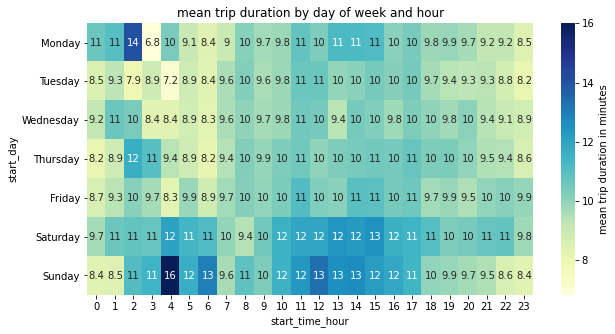

In [32]:
# Finding the start_day of week
bike_final['start_day']= bike_final['start_time'].dt.day_name()

# ordering the start_day of week
day_label = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_label_order= pd.api.types.CategoricalDtype(categories= day_label, ordered= True)
bike_final['start_day'] = bike_final['start_day'].astype(day_label_order)

# Finding start time hour
bike_final['start_time_hour']= bike_final['start_time'].dt.hour

# Calculating ride duration in minutes and adding a new column
bike_final['duration_min']= round((bike_final['duration_sec']/60),2)

data= pd.DataFrame(bike_final.groupby(['start_day','start_time_hour']).mean()['duration_min'])
data = data.reset_index()

bike_pivot  = data.pivot_table(values = 'duration_min',index = 'start_day', columns='start_time_hour')
plt.figure(figsize= [10,5])
sb.heatmap(bike_pivot, annot = True  , cmap="YlGnBu", cbar_kws={"label":'mean trip duration in minutes'} )
plt.title('mean trip duration by day of week and hour')
plt.show()